***1.Build a Siamese network for part matching with limited samples***

In [ ]:
!pip install -q torch torchvision tqdm

import torch, random
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
print("torch", torch.__version__)

class SiameseDataset(Dataset):
    def __init__(self, base_dataset, transform=None, num_pairs=6000):
        self.base = base_dataset
        self.transform = transform
        self.num_pairs = num_pairs
        self.class_to_idx = {}
        for i in range(len(self.base)):
            _, label = self.base[i]
            self.class_to_idx.setdefault(label, []).append(i)
        self.classes = list(self.class_to_idx.keys())
    def __len__(self): return self.num_pairs
    def __getitem__(self, idx):
        if random.random() < 0.5:
            cls = random.choice(self.classes)
            i1, i2 = random.sample(self.class_to_idx[cls], 2)
            img1, _ = self.base[i1]
            img2, _ = self.base[i2]
            label = 1.0
        else:
            c1, c2 = random.sample(self.classes, 2)
            i1 = random.choice(self.class_to_idx[c1])
            i2 = random.choice(self.class_to_idx[c2])
            img1, _ = self.base[i1]
            img2, _ = self.base[i2]
            label = 0.0
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor(label, dtype=torch.float32)

class SiameseNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*7*7,512), nn.ReLU(),
            nn.Linear(512,embedding_dim)
        )
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim,128), nn.ReLU(),
            nn.Linear(128,1)
        )
    def embed(self,x): return self.cnn(x)
    def forward(self,x1,x2):
        e1 = self.embed(x1)
        e2 = self.embed(x2)
        dist = torch.abs(e1-e2)
        return self.classifier(dist).squeeze(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor()])
train_base = FashionMNIST(root='./data', train=True, download=True, transform=None)
ds = SiameseDataset(train_base, transform=transform, num_pairs=6000)
dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=2)
model = SiameseNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
epochs = 3
for ep in range(epochs):
    model.train()
    pbar = tqdm(dl, desc=f'Epoch {ep+1}/{epochs}')
    running = 0.0
    for x1,x2,y in pbar:
        x1,x2,y = x1.to(device), x2.to(device), y.to(device)
        out = model(x1,x2)
        loss = criterion(out,y)
        opt.zero_grad(); loss.backward(); opt.step()
        running += loss.item()
        pbar.set_postfix(loss=running/(pbar.n+1))
print("Siamese training finished")

model.eval()
with torch.no_grad():
    for _ in range(5):
        idx = random.randrange(len(ds))
        x1,x2,y = ds[idx]
        logits = model(x1.unsqueeze(0).to(device), x2.unsqueeze(0).to(device))
        print("label", float(y.item()), "logit", float(logits.item()))


torch 2.8.0+cu126


Epoch 3/3: 100%|██████████| 94/94 [00:17<00:00,  5.40it/s, loss=0.338]

Siamese training finished
label 1.0 logit 1.1607321500778198
label 1.0 logit 1.2807942628860474
label 0.0 logit -6.93443489074707
label 0.0 logit -1.1151032447814941
label 0.0 logit -13.29568862915039


Similarity: 0.7711002230644226


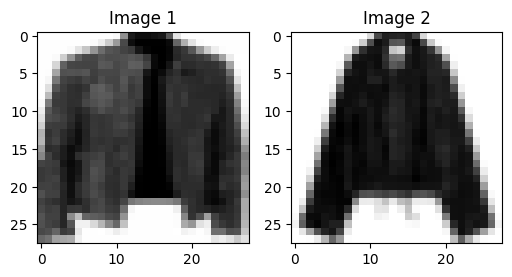

In [ ]:
from PIL import Image
import torchvision.transforms as T

transform = T.Compose([T.Grayscale(), T.Resize((28,28)), T.ToTensor()])

img1 = transform(Image.open("/content/download.webp")).unsqueeze(0).to(device)
img2 = transform(Image.open("/content/shopping (2).webp")).unsqueeze(0).to(device)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(img1.squeeze().cpu().numpy(), cmap='gray')
ax[0].set_title("Image 1")
ax[1].imshow(img2.squeeze().cpu().numpy(), cmap='gray')
ax[1].set_title("Image 2")

model.eval()
with torch.no_grad():
    logit = model(img1, img2)
    prob = torch.sigmoid(logit).item()
    print("Similarity:", prob)

***2.Train an Autoencoder on defect free samples to detect anomalies***

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ipythonx/mvtec-ad")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mvtec-ad' dataset.
Path to dataset files: /kaggle/input/mvtec-ad


In [ ]:
!pip install -q torch torchvision tqdm

In [ ]:
import os, torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
print("torch", torch.__version__)

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3,32,4,2,1), nn.ReLU(),
            nn.Conv2d(32,64,4,2,1), nn.ReLU(),
            nn.Conv2d(64,128,4,2,1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*8*8, latent_dim)
        )
        self.dec_lin = nn.Linear(latent_dim, 128*8*8)
        self.dec = nn.Sequential(
            nn.Unflatten(1,(128,8,8)),
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(32,3,4,2,1), nn.Sigmoid()
        )
    def forward(self,x):
        z = self.enc(x)
        xhat = self.dec(self.dec_lin(z))
        return xhat

good_dir = '/kaggle/input/mvtec-ad'
transform = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

ds = None
dl = None

if os.path.exists(good_dir):
    ds = ImageFolder(good_dir, transform=transform)
    dl = DataLoader(ds, batch_size=32, shuffle=True, num_workers=2)
    print("Found", len(ds), "images for training")
else:
    print("Please set good_dir to your folder with training images (ImageFolder structure)")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
epochs = 5

if dl is not None:
    for ep in range(epochs):
        model.train()
        pbar = tqdm(dl, desc=f'AE Epoch {ep+1}/{epochs}')
        running = 0.0
        for x,_ in pbar:
            x = x.to(device)
            xhat = model(x)
            loss = criterion(xhat, x)
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item()
            pbar.set_postfix(loss=running/(pbar.n+1))
    print("Autoencoder training done")

    model.eval()
    with torch.no_grad():
        if len(ds) > 0:
            x,_ = ds[0]
            x = x.unsqueeze(0).to(device)
            xhat = model(x)
            mse = F.mse_loss(xhat, x).item()
            print("Sample reconstruction MSE:", mse)
        else:
            print("Cannot perform sample reconstruction: Dataset is empty.")
else:
    print("Autoencoder training skipped due to missing or invalid training data.")

torch 2.8.0+cu126
Found 6612 images for training


AE Epoch 5/5: 100%|██████████| 207/207 [03:54<00:00,  1.13s/it, loss=0.00416]

Autoencoder training done
Sample reconstruction MSE: 0.011660666204988956
